In [1]:

import os
from os.path import join
import yaml
import pickle
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm
import torch

import ili
from ili.dataloaders import StaticNumpyLoader, SBISimulator
from ili.validation.runner import ValidationRunner 
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


from CASBI.generator.fff.fff_model import FreeFormFlow
from CASBI.utils.create_dataframe import rescale


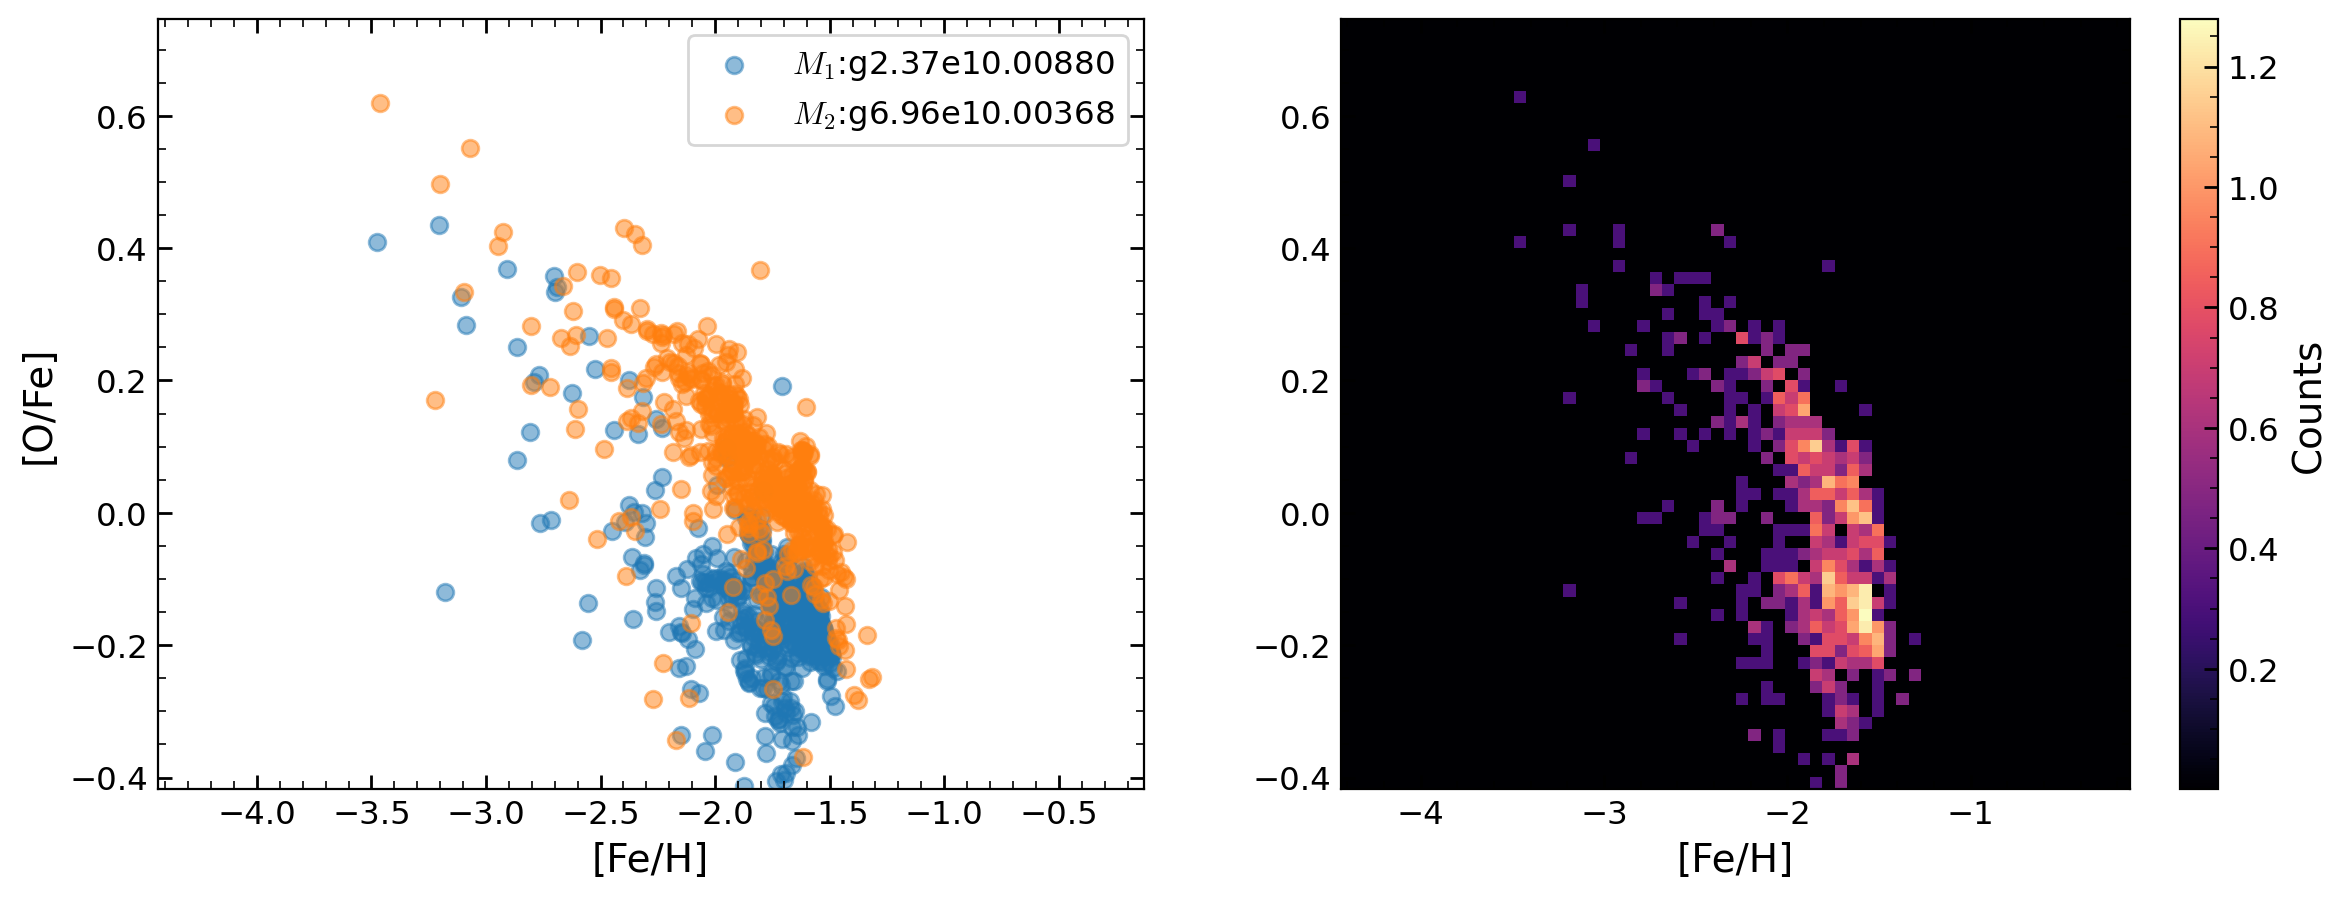

In [2]:
data = pd.read_parquet('../../../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameter=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])

data_to_plot_halos = pd.read_parquet('./halos_0.parquet')

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
for i, galaxy in enumerate(data_to_plot_halos['Galaxy_name'].unique()):
    observables =  data_to_plot_halos[data_to_plot_halos['Galaxy_name'] == galaxy]
    ax.scatter(observables['feh'], observables['ofe'], label=f'$M_{i+1}$:{galaxy}',alpha=0.5)
    ax.set_xlabel('[Fe/H]')   
    ax.set_ylabel('[O/Fe]')
    ax.set_xlim((min_feh, max_feh))
    ax.set_ylim((min_ofe, max_ofe))
    ax.legend()
ax = fig.add_subplot(122)
im = ax.imshow(np.load('x_0.npy').T, origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='magma')
ax.set_xlabel('[Fe/H]')   
# ax.set_ylabel('[O/Fe]')
cbar = fig.colorbar(im, ax=ax, label='Counts')
cbar.set_label('Counts', size=14)

fig.savefig('scatter_2subhalos.png')

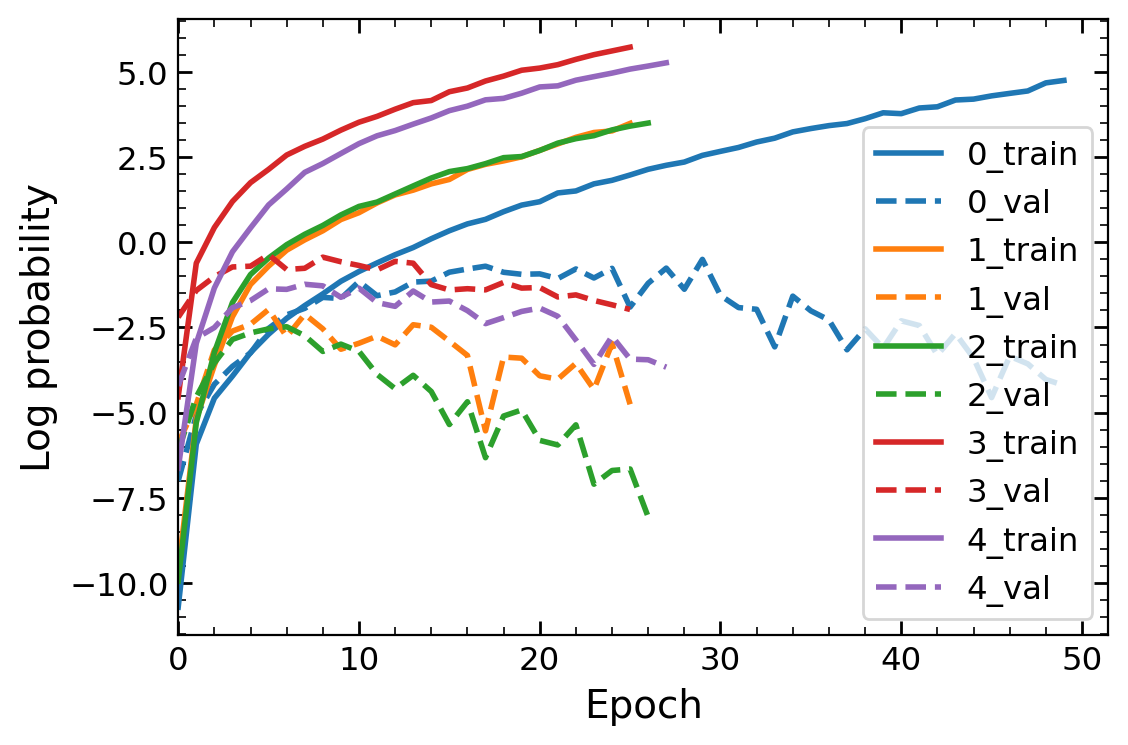

In [3]:
# Open the JSON file
with open('toy_NPE_summary.json', 'r') as f:
    # Load the data from the file
    summaries = json.load(f)
    
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [4]:
labels = [r'$\log_{10}(M_{s, 1})\ [M_\odot]$', r'$\log_{10}(M_{s, 2})\ [M_\odot]$', r'$\log_{10}(M_{DM, 1})\ [M_\odot]$', r'$\log_{10}(M_{DM, 2})\ [M_\odot]$', r'$\tau_{1}\ [Gyr]$', r'$\tau_{2}\ [Gyr]$']

samples = {}
m = 'NPE'
with open(join('./', 'toy_NPE_posterior.pkl'), 'rb') as f:
    samples[m] = pickle.load(f)
posterio_samples = samples['NPE'].sample((5_000,), x=torch.from_numpy(np.load('./x_0.npy')).to('cuda'))

Drawing 1659 posterior samples:   0%|          | 0/1659 [00:00<?, ?it/s]

Drawing 409 posterior samples:   0%|          | 0/409 [00:00<?, ?it/s]

Drawing 220 posterior samples:   0%|          | 0/220 [00:00<?, ?it/s]

Drawing 1910 posterior samples:   0%|          | 0/1910 [00:00<?, ?it/s]

/export/home/vgiusepp/.local/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(


Drawing 802 posterior samples:   0%|          | 0/802 [00:00<?, ?it/s]

Drawing 3304 posterior samples:   0%|          | 0/3304 [00:00<?, ?it/s]

Drawing 732 posterior samples:   0%|          | 0/732 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 3848 posterior samples:   0%|          | 0/3848 [00:00<?, ?it/s]

Drawing 1645 posterior samples:   0%|          | 0/1645 [00:00<?, ?it/s]

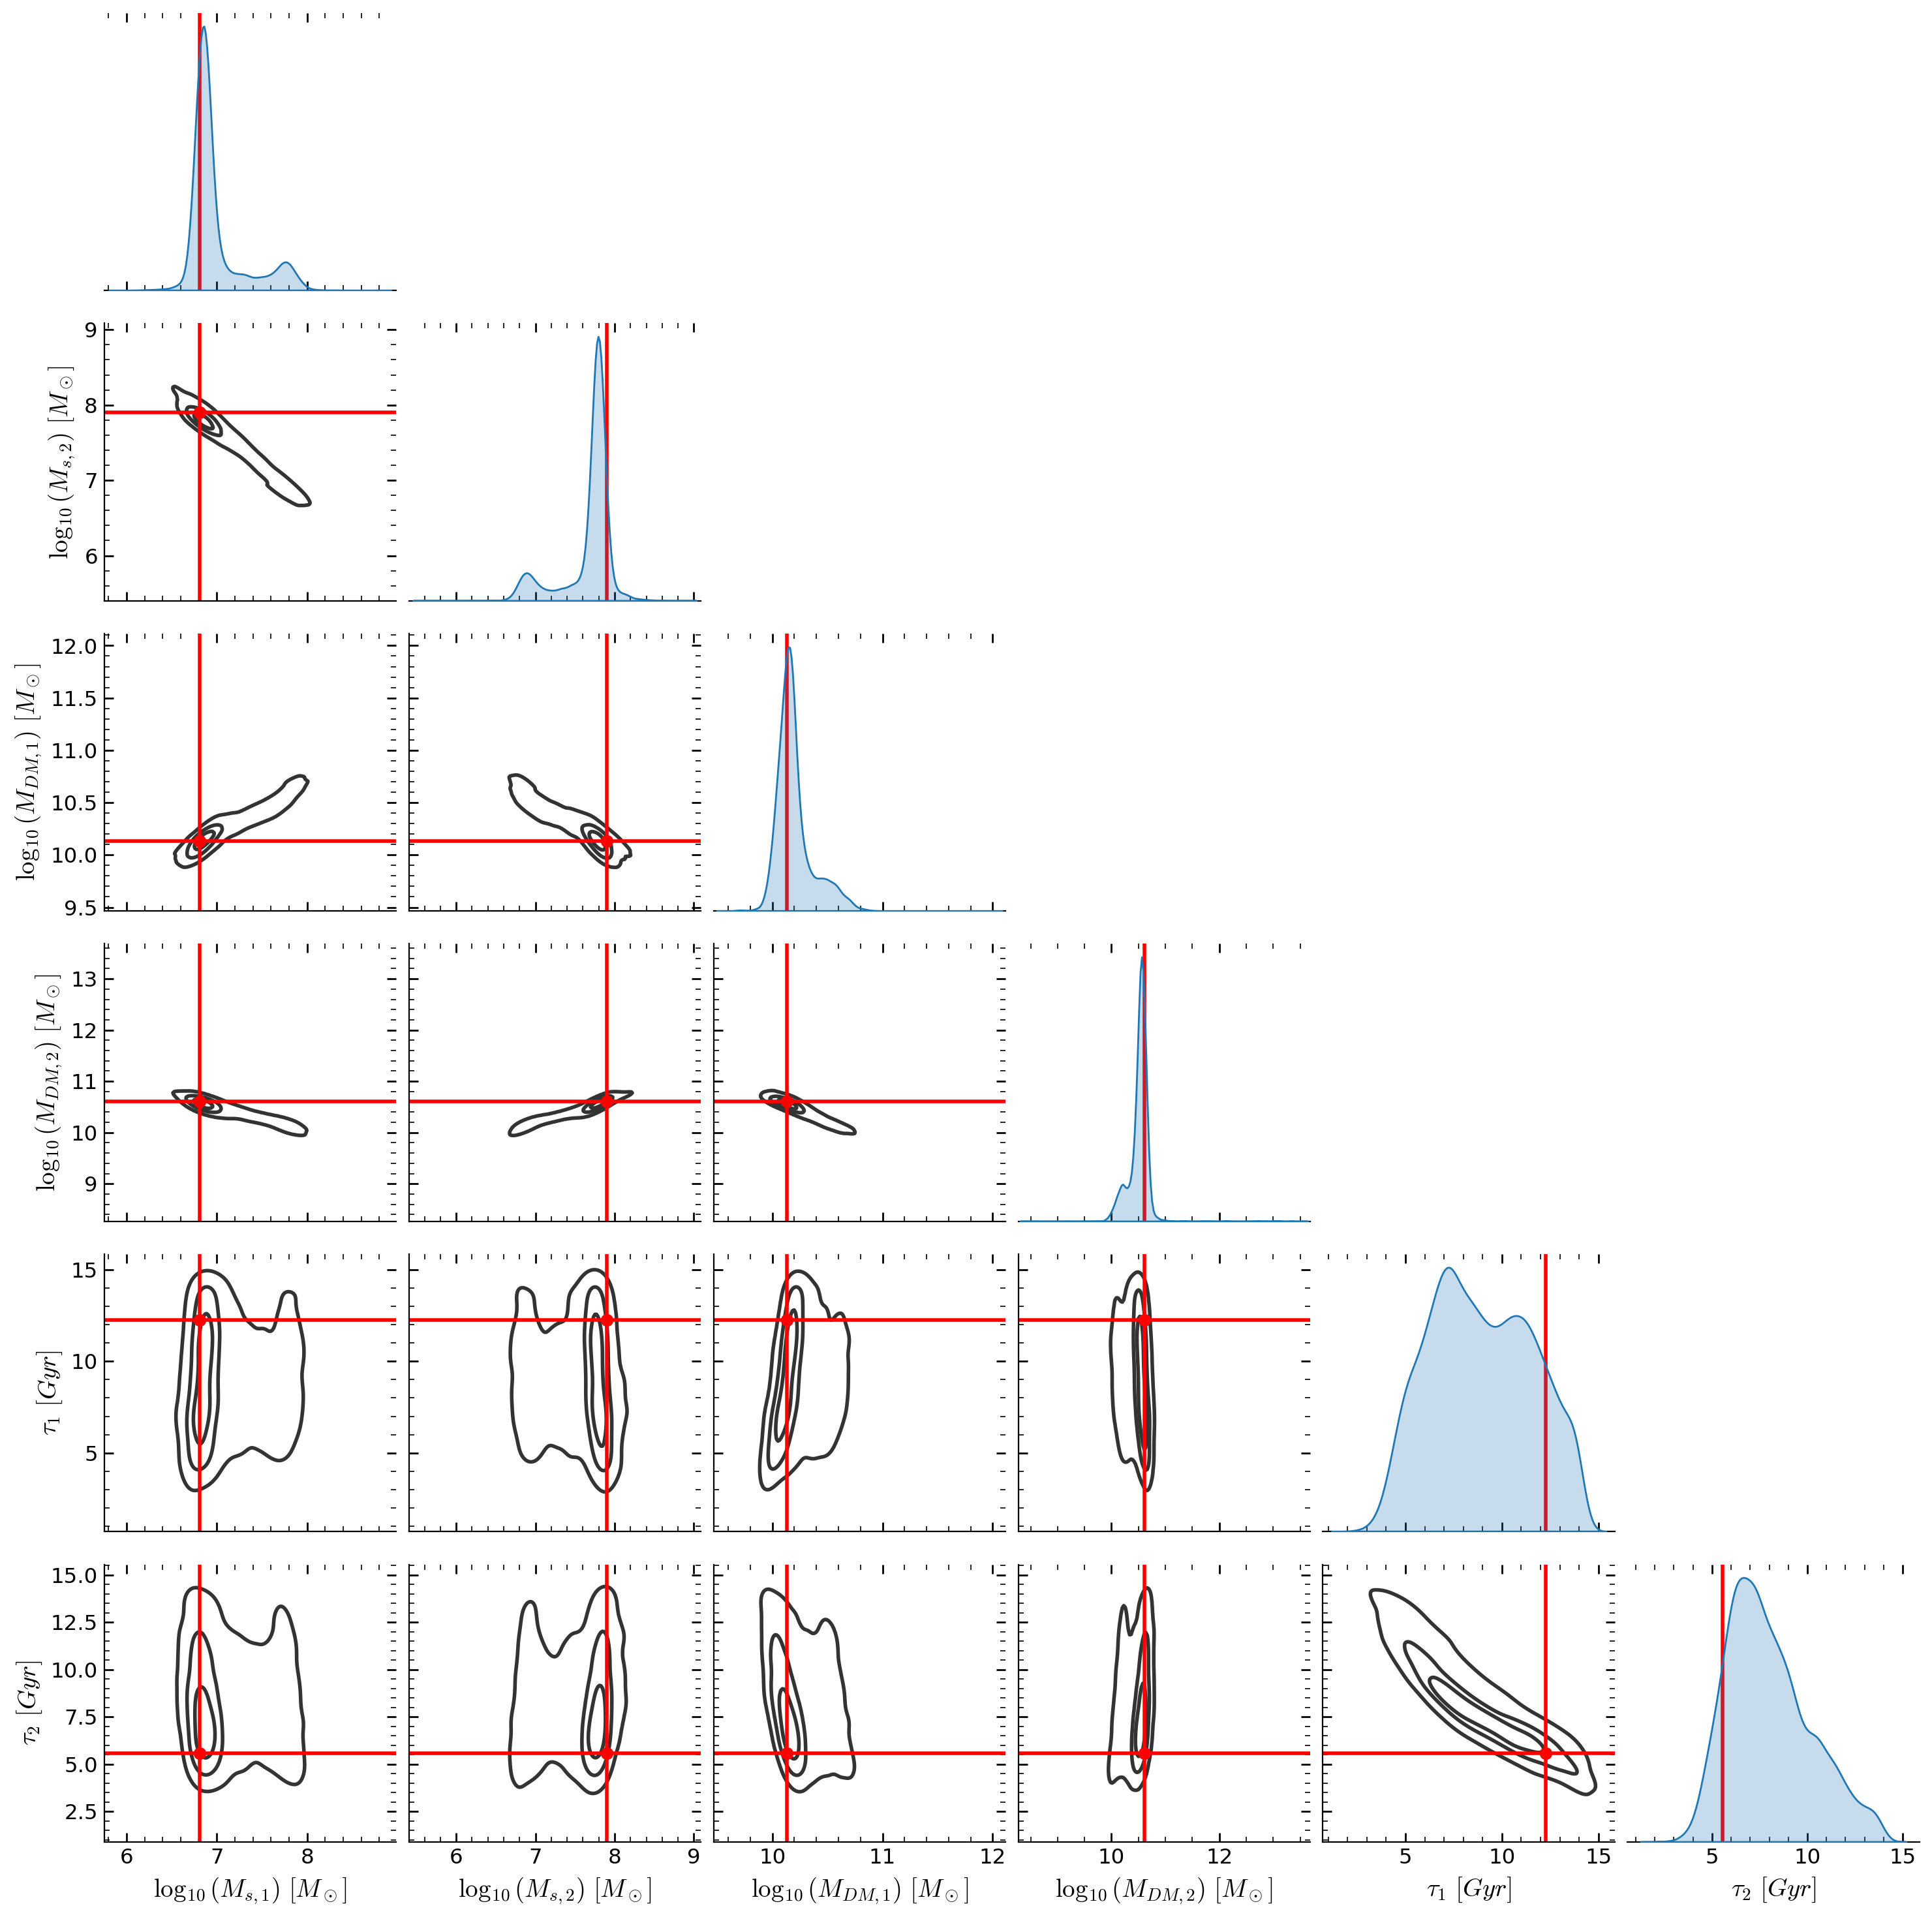

In [5]:
metric = PlotSinglePosterior(
    num_samples=10_000, sample_method='direct', 
    labels = labels,
    out_dir=None
)
fig = metric(
    posterior=samples[m],
    x_obs = torch.from_numpy(np.load('./x_0.npy')), theta_fid=torch.from_numpy(np.load('./theta_0.npy')),
)

fig.savefig('corner_2subhalos.png')

In [6]:
metric = PosteriorCoverage(num_samples=5000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=samples[m],
    x=torch.from_numpy(np.load('./x_test.npy')), theta=torch.from_numpy(np.load('./theta_test.npy'))
)

fig[3].savefig('coverage_2subhalos.png')

 35%|███▌      | 351/999 [01:41<03:08,  3.44it/s]WARNING:root:Only 0.000% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1936 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 35%|███▌      | 351/999 [14:43<27:10,  2.52s/it]


KeyboardInterrupt: 